<a href="https://colab.research.google.com/github/aayushsaini/road_data/blob/master/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/aayushsaini/road_data

fatal: destination path 'road_data' already exists and is not an empty directory.


In [ ]:
!ls road_data

driving_log.csv  IMG  readme.md


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
datadir = 'road_data'
columns = ['center', 'left', 'right', 'steering','throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,H:\Self-driving car data\IMG\center_2019_04_12_00_41_36_695.jpg,H:\Self-driving car data\IMG\left_2019_04_12_00_41_36_695.jpg,H:\Self-driving car data\IMG\right_2019_04_12_00_41_36_695.jpg,0.0,0.000000,0,2.810698
1,H:\Self-driving car data\IMG\center_2019_04_12_00_41_36_807.jpg,H:\Self-driving car data\IMG\left_2019_04_12_00_41_36_807.jpg,H:\Self-driving car data\IMG\right_2019_04_12_00_41_36_807.jpg,0.0,0.000000,0,2.782497
2,H:\Self-driving car data\IMG\center_2019_04_12_00_41_36_915.jpg,H:\Self-driving car data\IMG\left_2019_04_12_00_41_36_915.jpg,H:\Self-driving car data\IMG\right_2019_04_12_00_41_36_915.jpg,0.0,0.000000,0,2.749029
3,H:\Self-driving car data\IMG\center_2019_04_12_00_41_37_024.jpg,H:\Self-driving car data\IMG\left_2019_04_12_00_41_37_024.jpg,H:\Self-driving car data\IMG\right_2019_04_12_00_41_37_024.jpg,0.0,0.000000,0,2.721447
4,H:\Self-driving car data\IMG\center_2019_04_12_00_41_37_124.jpg,H:\Self-driving car data\IMG\left_2019_04_12_00_41_37_124.jpg,H:\Self-driving car data\IMG\right_2019_04_12_00_41_37_124.jpg,0.0,0.299551,0,2.961456


In [ ]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_12_00_41_36_695.jpg,left_2019_04_12_00_41_36_695.jpg,right_2019_04_12_00_41_36_695.jpg,0.0,0.000000,0,2.810698
1,center_2019_04_12_00_41_36_807.jpg,left_2019_04_12_00_41_36_807.jpg,right_2019_04_12_00_41_36_807.jpg,0.0,0.000000,0,2.782497
2,center_2019_04_12_00_41_36_915.jpg,left_2019_04_12_00_41_36_915.jpg,right_2019_04_12_00_41_36_915.jpg,0.0,0.000000,0,2.749029
3,center_2019_04_12_00_41_37_024.jpg,left_2019_04_12_00_41_37_024.jpg,right_2019_04_12_00_41_37_024.jpg,0.0,0.000000,0,2.721447
4,center_2019_04_12_00_41_37_124.jpg,left_2019_04_12_00_41_37_124.jpg,right_2019_04_12_00_41_37_124.jpg,0.0,0.299551,0,2.961456


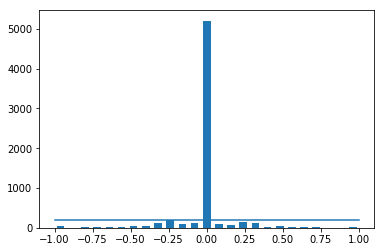

In [ ]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins) 
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6544
removed: 5005
remaining: 1539


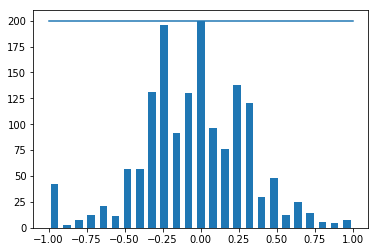

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True) 
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_04_12_00_41_39_108.jpg
left        left_2019_04_12_00_41_39_108.jpg  
right       right_2019_04_12_00_41_39_108.jpg 
steering   -0.15                              
throttle    1                                 
reverse     0                                 
speed       23.504                            
Name: 24, dtype: object


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training samples: {} \n Validation Samples: {}'.format(len(x_train),len(x_valid)))

Training samples: 1231 
 Validation Samples: 308


Text(0.5, 1.0, 'Validation set')

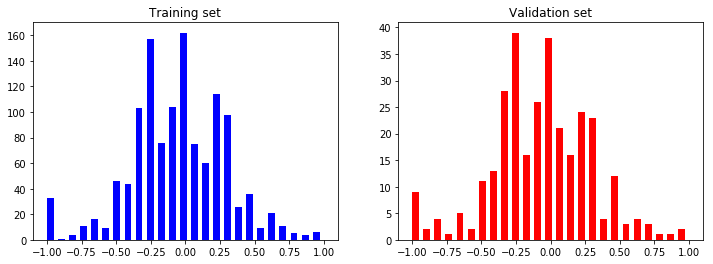

In [ ]:
fig, axis = plt.subplots(1, 2, figsize = (12, 4))
axis[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axis[0].set_title('Training set')
axis[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axis[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[69:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255  #normalisation
    return img

Text(0.5, 1.0, 'Zoomed Image')

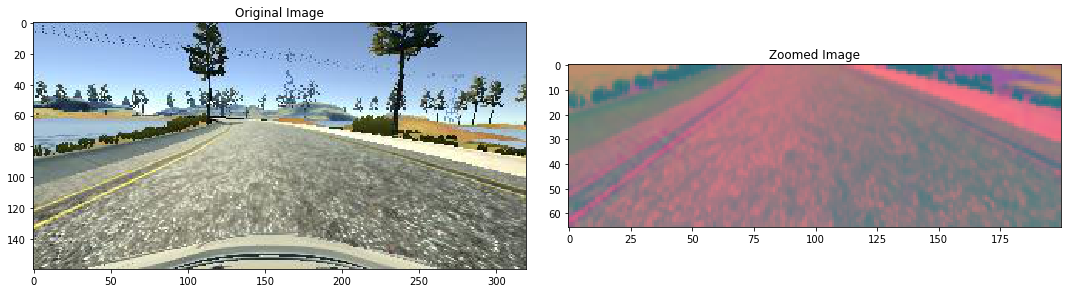

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
zoomed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))

In [ ]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
  
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
  
    model.add(Flatten())
  
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
  
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

(1231, 66, 200, 3)


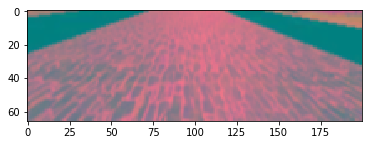

In [ ]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])

print(x_train.shape)

In [ ]:
model = nvidia_model()
print(model.summary())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

In [ ]:
history = model.fit(x_train, y_train, epochs = 30, validation_data = (x_valid, y_valid), batch_size = 100, verbose = 1, shuffle = 1)

Train on 1231 samples, validate on 308 samples
Epoch 1/30
1231/1231 [==============================] - 25s 20ms/step - loss: 0.7351 - val_loss: 0.1235
Epoch 2/30
1231/1231 [==============================] - 22s 18ms/step - loss: 0.2141 - val_loss: 0.1228
Epoch 3/30
1231/1231 [==============================] - 23s 19ms/step - loss: 0.1699 - val_loss: 0.1181
Epoch 4/30
1231/1231 [==============================] - 23s 18ms/step - loss: 0.1320 - val_loss: 0.1150
Epoch 5/30
1231/1231 [==============================] - 22s 18ms/step - loss: 0.1446 - val_loss: 0.1159
Epoch 6/30
1231/1231 [==============================] - 23s 19ms/step - loss: 0.1256 - val_loss: 0.1118
Epoch 7/30
1231/1231 [==============================] - 21s 17ms/step - loss: 0.1183 - val_loss: 0.1028
Epoch 8/30
1231/1231 [==============================] - 11s 9ms/step - loss: 0.1179 - val_loss: 0.1050
Epoch 9/30
1231/1231 [==============================] - 11s 9ms/step - loss: 0.1174 - val_loss: 0.1064
Epoch 10/30
1231/12

Text(0.5, 0, 'Epochs')

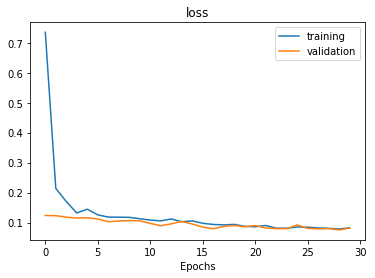

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('Epochs')

In [ ]:
model.save('model_a.h5')

In [ ]:
from google.colab import files
files.download('model_a.h5')